## Python Code
### 21_engineer_volcanic_eruption_data.ipynb
<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"><b>This script cleans, engineers, and selects volcano and eruption data from the Smithsonian Institution databases.</b> The main parts of the routines were developed in previous courses at the University of London by the same author (Mohr, 2021, 2023, 2024a) and have been further refined to meet the needs of this MSc thesis project/research. However, the code has been updated to comply with the latest requirements and package interdependencies. Some comments will be included in this Jupyter Notebook, and the code contains several inline comments. For details on the project/research itself, refer to the appropriate document.

#### References (for this script)
*Mohr, S. (2021) Regional Spatial Clusters of Earthquakes at the Pacific Ring of Fire: Analysing Data from the USGS ANSS ComCat and Building Regional Spatial Clusters. DSM020, Python, examined coursework cw1. University of London.*

*Mohr, S. (2023) Clustering of Earthquakes on a Worldwide Scale with the Help of Big Data Machine Learning Methods. DSM010, Big Data, examined coursework cw2. University of London.*

*Mohr, S. (2024a) Comparing Different Tectonic Setups Considering Publicly Available Basic Earthquake’s Data. DSM050, Data Visualisation, examined coursework cw1. University of London.*

#### History
<pre>
250104 Generation from previous courseworks at the UoL, setup basic logging, re-writing anything to two datasets,
       cleaning, engineering, preliminary results
250105 Move shared procedures to shared_procedures.py, engineer features geo_x, geo_y (for clustering),
       check selected volcanoes and eruptions
250110 Clean volcanoes outliers at intraplate locations and outside study area, ensure spatial fitting,
       delete uncertain eruptions and several other unclear or uncertain events or locations,
       moved info about active or ongoing eruptions, drop feature 'Not_Study_Area', adding feature 'Erupting'
250112 Use buffered SHP file in QGIS for determing the Volcano_Number and deleting volcanoes off plate margins
</pre>

#### Todo
<pre>./.</pre>

## Preparing the environment
### System information

In [1]:
# which python installation and version are we using here?
print('\n******* Python Info ***********')
!which python
!python --version

# show some CPU and RAM info
print('\n******* CPU Info ***********')
!lscpu
print('\n******* RAM Info (in GB) ***********')
!free -g


******* Python Info ***********
/bin/python
Python 3.8.10

******* CPU Info ***********
Architecture:                       x86_64
CPU op-mode(s):                     32-bit, 64-bit
Byte Order:                         Little Endian
Address sizes:                      46 bits physical, 48 bits virtual
CPU(s):                             64
On-line CPU(s) list:                0-63
Thread(s) per core:                 2
Core(s) per socket:                 8
Socket(s):                          4
NUMA node(s):                       4
Vendor ID:                          GenuineIntel
CPU family:                         6
Model:                              85
Model name:                         Intel(R) Xeon(R) Gold 6234 CPU @ 3.30GHz
Stepping:                           7
CPU MHz:                            1200.065
CPU max MHz:                        4000.0000
CPU min MHz:                        1200.0000
BogoMIPS:                           6600.00
Virtualization:                     VT-x
L1

In [2]:
# show installed packages and versions
!pip freeze

absl-py==2.1.0
affine==2.4.0
aggdraw==1.3.16
arch==5.6.0
array-record==0.4.0
astropy==5.2.2
asttokens==2.4.1
astunparse==1.6.3
atomicwrites==1.1.5
attrs==19.3.0
Automat==0.8.0
backcall==0.2.0
beautifulsoup4==4.8.2
blinker==1.4
branca==0.8.1
cachetools==5.5.0
certifi==2019.11.28
cftime==1.6.4.post1
chardet==3.0.4
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloud-init==24.3.1
colorama==0.4.3
comm==0.2.2
command-not-found==0.3
configobj==5.0.6
confluent-kafka==2.5.3
constantly==15.1.0
contextily==1.5.2
contourpy==1.1.1
cryptography==2.8
cupshelpers==1.0
cycler==0.10.0
dbus-python==1.2.16
debugpy==1.8.7
decorator==4.4.2
defer==1.0.6
distro==1.4.0
distro-info==0.23+ubuntu1.1
dm-tree==0.1.8
dtw==1.4.0
entrypoints==0.3
et-xmlfile==1.0.1
etils==1.3.0
executing==2.0.1
fail2ban==0.11.1
fastjsonschema==2.20.0
filelock==3.13.1
fiona==1.9.6
flatbuffers==24.3.25
folium==0.18.0
fonttools==4.53.1
frites==0.4.4
fsspec==2023.12.2
ftfy==6.2.0
gast==0.4.0
geodatasets==2024.8.0
geographiclib==2.0
geopan

### Setting PATH correctly

In [3]:
# there is somewhere a PATH-error on LENA for a while
# adding my packages path to the PATH environment

import sys
sys.path.append("/home/smohr001/.local/lib/python3.8/site-packages")
sys.path

['/home/smohr001/thesis',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/opt/jupyterhub/lib/python3.8/site-packages',
 '/opt/jupyterhub/lib/python3.8/site-packages/IPython/extensions',
 '/home/smohr001/.ipython',
 '/home/smohr001/.local/lib/python3.8/site-packages']

### Loading libraries

In [4]:
# importing standard libraries
import sys
import os
import warnings
import datetime
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import logging

# importing shared procedures for this procect (needs to be a simple .py file)
%run shared_procedures.py

# importing additional libraries
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt

# get info about installed and used versions of some important (deep learning) libraries
print("Some important installed libraries:\n")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Seaborn version: {sns.__version__}")

Some important installed libraries:

Pandas version: 1.4.1
Numpy version: 1.22.2
Seaborn version: 0.13.2


### Setting the script environment

In [5]:
# show all matplotlib graphs inline
%matplotlib inline

# setting format to JPG for easy copy & paste for figures
# for high quality outputs choose 'svg'
%config InlineBackend.figure_format = 'jpg'

# adjust display settings to show 20 rows as a standard
pd.set_option('display.max_rows', 20)

# disable warnings (activate after developing the complete code)
warnings.filterwarnings('ignore')

# set script (ipynb notebook) name (e.g. for logging)
script_name = "21_engineer_volcanic_eruption_data.ipynb"

# start parameterized logging
setup_logging(logfile_dir = "log", 
              logfile_name = "20_engineer_data.log", 
              log_level = logging.INFO, 
              script_name = script_name
             )

# set data directory
data_dir = "data"
logging.info(f"{script_name}: Set data directory to './{data_dir}'.")

2025-01-22 02:15:53,288 - INFO - Starting script '21_engineer_volcanic_eruption_data.ipynb'.
2025-01-22 02:15:53,289 - INFO - Set loglevel to INFO.
2025-01-22 02:15:53,290 - INFO - 21_engineer_volcanic_eruption_data.ipynb: Set data directory to './data'.


In [6]:
# set fixed seed for reproducibility
reset_random_seeds(script_name=script_name)

2025-01-22 02:15:53,292 - INFO - 21_engineer_volcanic_eruption_data.ipynb: Seeding random generators with seed=654321.


## Loading data

In [7]:
# load scraped datasets
volcanoes_scraped = load_dataset(data_file="volcanoes_scraped.csv", data_dir="data")
eruptions_scraped = load_dataset(data_file="eruptions_scraped.csv", data_dir="data")

2025-01-22 02:15:53,302 - INFO - load_dataset: Data loaded successfully from 'data/volcanoes_scraped.csv'.
2025-01-22 02:15:53,322 - INFO - load_dataset: Data loaded successfully from 'data/eruptions_scraped.csv'.


## Statistics and information

In [8]:
# infos of the datasets
print("Volcanoes")
pd.set_option('display.max_rows', None)
print("\nShape:\n" + str(volcanoes_scraped.shape))
print("\nColumns and DataTypes:\n" + str(volcanoes_scraped.dtypes))
pd.set_option('display.max_rows', 20)
display(volcanoes_scraped)
logging.info(f"{script_name}: Used dataset is 'volcanoes_scraped' with {volcanoes_scraped.shape}.")

print("\nEruptions")
pd.set_option('display.max_rows', None)
print("\nShape:\n" + str(eruptions_scraped.shape))
print("\nColumns and DataTypes:\n" + str(eruptions_scraped.dtypes))
pd.set_option('display.max_rows', 20)
display(eruptions_scraped)
logging.info(f"{script_name}: Used dataset is 'eruptions_scraped' with {eruptions_scraped.shape}.")

Volcanoes

Shape:
(1281, 11)

Columns and DataTypes:
Volcano_Number            int64
Volcano_Name             object
Primary_Volcano_Type     object
Country                  object
Region                   object
Latitude                float64
Longitude               float64
Elevation                 int64
Tectonic_Setting         object
Evidence_Category        object
Major_Rock_Type          object
dtype: object


,Volcano_Number,Volcano_Name,Primary_Volcano_Type,Country,Region,Latitude,Longitude,Elevation,Tectonic_Setting,Evidence_Category,Major_Rock_Type
0,210010,West Eifel Volcanic Field,Volcanic field,Germany,European Volcanic Regions,50.1700,6.8500,600,Rift zone / Continental crust (> 25 km),Eruption Dated,Foidite
1,210020,Chaine des Puys,Lava dome(s),France,European Volcanic Regions,45.7860,2.9810,1464,Rift zone / Continental crust (> 25 km),Eruption Dated,Basalt / Picro-Basalt
2,210030,Olot Volcanic Field,Volcanic field,Spain,European Volcanic Regions,42.1700,2.5300,893,Intraplate / Continental crust (> 25 km),Evidence Credible,Trachybasalt / Tephrite Basanite
3,210040,Calatrava Volcanic Field,Volcanic field,Spain,European Volcanic Regions,38.8700,-4.0200,1117,Intraplate / Continental crust (> 25 km),Eruption Dated,Basalt / Picro-Basalt
4,211004,Colli Albani,Caldera,Italy,European Volcanic Regions,41.7569,12.7251,949,Subduction zone / Continental crust (> 25 km),Evidence Uncertain,Foidite
...,...,...,...,...,...,...,...,...,...,...,...
1276,221294,Northern Lake Abaya Volcanic Field,Volcanic field,Ethiopia,Eastern Africa Volcanic Regions,6.7600,37.9700,1594,Intraplate / Continental crust (> 25 km),Evidence Credible,NaN
1277,221330,Mega Volcanic Field,Volcanic field,Ethiopia,Eastern Africa Volcanic Regions,3.9710,38.2130,1500,Rift zone / Intermediate crust (15-25 km),Evidence Credible,NaN
1278,312055,Stepovak Bay Group,Volcanic field,United States,North America Volcanic Regions,55.9170,-160.0170,1633,Subduction zone / Continental crust (> 25 km),Evidence Credible,NaN
1279,244021,Malumalu,Stratovolcano,United States,Southern Pacific Volcanic Regions,-14.6010,-169.7870,-145,Intraplate / Oceanic crust (< 15 km),Evidence Credible,NaN


2025-01-22 02:15:53,336 - INFO - 21_engineer_volcanic_eruption_data.ipynb: Used dataset is 'volcanoes_scraped' with (1281, 11).



Eruptions

Shape:
(11130, 21)

Columns and DataTypes:
Volcano_Number                int64
Volcano_Name                 object
Eruption_Number               int64
Activity_Type                object
ExplosivityIndexMax         float64
ExplosivityIndexModifier     object
ActivityArea                 object
ActivityUnit                 object
StartEvidenceMethod          object
StartDateYearModifier        object
StartDateYear                 int64
StartDateMonth              float64
StartDateDayModifier         object
StartDateDay                float64
EndDateYearModifier          object
EndDateYear                 float64
EndDateMonth                float64
EndDateDayModifier           object
EndDateDay                  float64
Longitude                   float64
Latitude                    float64
dtype: object


,Volcano_Number,Volcano_Name,Eruption_Number,Activity_Type,ExplosivityIndexMax,ExplosivityIndexModifier,ActivityArea,ActivityUnit,StartEvidenceMethod,StartDateYearModifier,...,StartDateMonth,StartDateDayModifier,StartDateDay,EndDateYearModifier,EndDateYear,EndDateMonth,EndDateDayModifier,EndDateDay,Longitude,Latitude
0,213021,Suphan Dagi,13907,Uncertain Eruption,NaN,NaN,NaN,NaN,Correlation: Tephrochronology,?,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,42.833,38.931
1,213020,Nemrut Dagi,10039,Confirmed Eruption,NaN,NaN,NaN,NaN,Sidereal: Varve Count,?,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,42.229,38.654
2,213020,Nemrut Dagi,10044,Confirmed Eruption,NaN,NaN,NaN,NaN,Sidereal: Varve Count,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,42.229,38.654
3,213020,Nemrut Dagi,10056,Confirmed Eruption,NaN,NaN,NaN,NaN,Sidereal: Varve Count,?,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,42.229,38.654
4,213020,Nemrut Dagi,13312,Confirmed Eruption,NaN,NaN,NaN,NaN,Sidereal: Varve Count,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,42.229,38.654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11125,600000,Unknown Source,13237,Confirmed Eruption,NaN,NaN,"(GISP2,109 ppb sulfate)",NaN,Sidereal: Ice Core,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11126,600000,Unknown Source,13238,Confirmed Eruption,NaN,NaN,"(GISP2, 94 ppb sulfate)",NaN,Sidereal: Ice Core,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11127,600000,Unknown Source,13239,Confirmed Eruption,NaN,NaN,"(GISP2, 109 ppb sulfate)",NaN,Sidereal: Ice Core,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128,600000,Unknown Source,13240,Confirmed Eruption,NaN,NaN,"(GISP2, 97 ppb sulfate)",NaN,Sidereal: Ice Core,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2025-01-22 02:15:53,353 - INFO - 21_engineer_volcanic_eruption_data.ipynb: Used dataset is 'eruptions_scraped' with (11130, 21).


## Cleaning

In [9]:
# make a deep copy of the datasets for further processing
volcanoes_cleaned = volcanoes_scraped.copy()
eruptions_cleaned = eruptions_scraped.copy()
logging.info(f"{script_name}: Used dataset is 'volcanoes_cleaned' with {volcanoes_cleaned.shape}.")
logging.info(f"{script_name}: Used dataset is 'eruptions_cleaned' with {eruptions_cleaned.shape}.")

2025-01-22 02:15:53,356 - INFO - 21_engineer_volcanic_eruption_data.ipynb: Used dataset is 'volcanoes_cleaned' with (1281, 11).
2025-01-22 02:15:53,357 - INFO - 21_engineer_volcanic_eruption_data.ipynb: Used dataset is 'eruptions_cleaned' with (11130, 21).


### Duplicates

In [10]:
# check for any duplicates
print("Volcanoes")
show_duplicates(volcanoes_cleaned)

print("\nEruptions")
show_duplicates(eruptions_cleaned)

Volcanoes
No duplicates found.

Eruptions
No duplicates found.


### Possible data errors

In [11]:
# get and show data errors
print("Volcanoes")
print("Columns with possible data errors (empty output means no columns detected):")
data_errors_volcanoes_cleaned = pd.DataFrame(get_data_errors(volcanoes_cleaned)).fillna(0).transpose().applymap(lambda x: int(float(x)))
display(data_errors_volcanoes_cleaned)

print("\nEruptions")
print("Columns with possible data errors (empty output means no columns detected):")
data_errors_eruptions_cleaned = pd.DataFrame(get_data_errors(eruptions_cleaned)).fillna(0).transpose().applymap(lambda x: int(float(x)))
display(data_errors_eruptions_cleaned)

Volcanoes
Columns with possible data errors (empty output means no columns detected):


,0,nan
Elevation,1,0
Tectonic_Setting,0,5
Major_Rock_Type,0,25



Eruptions
Columns with possible data errors (empty output means no columns detected):


,0,nan,?
ExplosivityIndexMax,1005,2768,0
ExplosivityIndexModifier,0,9828,1098
ActivityArea,0,6262,0
ActivityUnit,0,10227,0
StartEvidenceMethod,0,1104,0
StartDateYearModifier,0,9535,1516
StartDateYear,1,0,0
StartDateMonth,4883,250,0
StartDateDayModifier,0,10726,297
StartDateDay,5684,254,0


Any missing values other than np.nan are replaced by np.nan for a consistent dataset and analysis.

In [12]:
# convert missing or corrupted values to np.nan
eruptions_cleaned.replace('?', np.nan, inplace=True)

### Cleaning eruptions

In [13]:
print("Shape of eruptions_cleaned before cleaning any rows:", eruptions_cleaned.shape)

Shape of eruptions_cleaned before cleaning any rows: (11130, 21)


#### Slice dataset to chosen time period

In [14]:
# select only eruptions inside the chosen timeframe 1970-2019
print("Volcanoes")
eruptions_cleaned = eruptions_cleaned[
    ((eruptions_cleaned['StartDateYear'] >= 1970) & (eruptions_cleaned['StartDateYear'] <= 2019)) |
    ((eruptions_cleaned['EndDateYear'] >= 1970) & (eruptions_cleaned['EndDateYear'] <= 2019))
]

print("Shape of eruptions_cleaned after slicing to timeframe:", eruptions_cleaned.shape)
print("Columns with possible data errors (empty output means no columns detected):")
data_errors_eruptions_cleaned = pd.DataFrame(get_data_errors(eruptions_cleaned)).fillna(0).transpose().applymap(lambda x: int(float(x)))
display(data_errors_eruptions_cleaned)

Volcanoes
Shape of eruptions_cleaned after slicing to timeframe: (2018, 21)
Columns with possible data errors (empty output means no columns detected):


,0,nan
ExplosivityIndexMax,316,58
ExplosivityIndexModifier,0,2016
ActivityArea,0,979
ActivityUnit,0,2013
StartEvidenceMethod,0,240
StartDateYearModifier,0,2013
StartDateDayModifier,0,1963
EndDateYearModifier,0,1992
EndDateYear,0,222
EndDateMonth,0,223


#### NAN-values
Now drop any eruptions where needed values or combinations are np.nan.

In [15]:
columns_to_display = [
    'ExplosivityIndexMax', 
    'StartEvidenceMethod', 
    'StartDateYear',
    'StartDateMonth', 
    'StartDateDay',
]

columns_to_check = ['EndDateDay', 
                    'EndDateMonth', 
                    'EndDateYear',
                    'StartEvidenceMethod',
                    'ExplosivityIndexMax'
                   ]

rows_to_drop = display(eruptions_cleaned[eruptions_cleaned[columns_to_check].isnull().all(axis=1)][columns_to_display])

,ExplosivityIndexMax,StartEvidenceMethod,StartDateYear,StartDateMonth,StartDateDay
823,NaN,NaN,1972,7.0,2.0
1079,NaN,NaN,2008,5.0,19.0
1941,NaN,NaN,1989,12.0,16.0
1956,NaN,NaN,1972,7.0,2.0
2466,NaN,NaN,1996,5.0,5.0
...,...,...,...,...,...
8716,NaN,NaN,1996,9.0,27.0
8717,NaN,NaN,1999,12.0,27.0
9836,NaN,NaN,1981,9.0,25.0
10343,NaN,NaN,1995,9.0,12.0


In [16]:
eruptions_cleaned = eruptions_cleaned[~eruptions_cleaned[columns_to_check].isnull().all(axis=1)]

print("Shape of eruptions_cleaned after slicing to timeframe:", eruptions_cleaned.shape)
print("Columns with possible data errors (empty output means no columns detected):")
data_errors_eruptions_cleaned = pd.DataFrame(get_data_errors(eruptions_cleaned)).fillna(0).transpose().applymap(lambda x: int(float(x)))
display(data_errors_eruptions_cleaned)

Shape of eruptions_cleaned after slicing to timeframe: (1991, 21)
Columns with possible data errors (empty output means no columns detected):


,0,nan
ExplosivityIndexMax,316,31
ExplosivityIndexModifier,0,1989
ActivityArea,0,957
ActivityUnit,0,1986
StartEvidenceMethod,0,213
StartDateYearModifier,0,1986
StartDateDayModifier,0,1936
EndDateYearModifier,0,1965
EndDateYear,0,195
EndDateMonth,0,196


In [17]:
# drop rows with nan ExplosivityIndexMax and 0 as a value
eruptions_cleaned.dropna(subset=['ExplosivityIndexMax'], inplace=True)
print("Shape of eruptions_cleaned after dropping rows:", eruptions_cleaned.shape)

Shape of eruptions_cleaned after dropping rows: (1960, 21)


#### StartEvidenceMethod
The *StartEvidenceMethod* features shows non-defined values, setting them to *unknown*.

In [18]:
# cleaning StartEvidenceMethod
eruptions_cleaned.loc[eruptions_cleaned['StartEvidenceMethod'].isna(), 'StartEvidenceMethod'] = 'unknown'
print("Shape of eruptions_cleaned after cleaning rows:", eruptions_cleaned.shape)

Shape of eruptions_cleaned after cleaning rows: (1960, 21)


#### Select minimum VEI

In [19]:
# select only eruptions inside the chosen timeframe 1970-2019
eruptions_cleaned = eruptions_cleaned[(eruptions_cleaned['ExplosivityIndexMax'] >= 1)]

print("Shape of eruptions_cleaned after slicing to timeframe:", eruptions_cleaned.shape)
print("Columns with possible data errors (empty output means no columns detected):")
data_errors_eruptions_cleaned = pd.DataFrame(get_data_errors(eruptions_cleaned)).fillna(0).transpose().applymap(lambda x: int(float(x)))
display(data_errors_eruptions_cleaned)

Shape of eruptions_cleaned after slicing to timeframe: (1644, 21)
Columns with possible data errors (empty output means no columns detected):


,nan
ExplosivityIndexModifier,1642
ActivityArea,781
ActivityUnit,1641
StartDateYearModifier,1642
StartDateDayModifier,1597
EndDateYearModifier,1624
EndDateYear,134
EndDateMonth,134
EndDateDayModifier,1561
EndDateDay,134


In [20]:
# Fill rows where ['EndDateDay', 'EndDateMonth', 'EndDateYear'] are all NaN
condition = eruptions_cleaned[['EndDateDay', 'EndDateMonth', 'EndDateYear']].isnull().all(axis=1)

# Update the end date columns with the corresponding start date values
eruptions_cleaned.loc[condition, 'EndDateDay'] = eruptions_cleaned.loc[condition, 'StartDateDay']
eruptions_cleaned.loc[condition, 'EndDateMonth'] = eruptions_cleaned.loc[condition, 'StartDateMonth']
eruptions_cleaned.loc[condition, 'EndDateYear'] = eruptions_cleaned.loc[condition, 'StartDateYear']

print("Shape of eruptions_cleaned after slicing to timeframe:", eruptions_cleaned.shape)
print("Columns with possible data errors (empty output means no columns detected):")
data_errors_eruptions_cleaned = pd.DataFrame(get_data_errors(eruptions_cleaned)).fillna(0).transpose().applymap(lambda x: int(float(x)))
display(data_errors_eruptions_cleaned)

Shape of eruptions_cleaned after slicing to timeframe: (1644, 21)
Columns with possible data errors (empty output means no columns detected):


,nan
ExplosivityIndexModifier,1642
ActivityArea,781
ActivityUnit,1641
StartDateYearModifier,1642
StartDateDayModifier,1597
EndDateYearModifier,1624
EndDateDayModifier,1561


### Volcanoes

In [21]:
print("Shape of volcanoes_cleaned before cleaning any rows:", volcanoes_cleaned.shape)

Shape of volcanoes_cleaned before cleaning any rows: (1281, 11)


### Major_Rock_Type
The *Major_Rock_Type* features shows non-defined values, setting them to *unknown*.

In [22]:
# cleaning StartEvidenceMethod
volcanoes_cleaned.loc[volcanoes_cleaned['Major_Rock_Type'].isna(), 'Major_Rock_Type'] = 'unknown'
volcanoes_cleaned.loc[volcanoes_cleaned['Major_Rock_Type'].isna(), 'Major_Rock_Type'] = 'unknown'
volcanoes_cleaned['Major_Rock_Type'] = volcanoes_cleaned['Major_Rock_Type'].replace('No Data (checked)', 'unknown')
print("Shape of volcanoes_cleaned after cleaning rows:", volcanoes_cleaned.shape)

Shape of volcanoes_cleaned after cleaning rows: (1281, 11)


### Tectonic_Setting
The *Tectonic_Setting* features shows non-defined values, setting them to *unknown*.

In [23]:
# cleaning Tectonic_Setting
volcanoes_cleaned.loc[volcanoes_cleaned['Tectonic_Setting'].isna(), 'Tectonic_Setting'] = 'Unknown'
print("Shape of volcanoes_cleaned after cleaning rows:", volcanoes_cleaned.shape)

Shape of volcanoes_cleaned after cleaning rows: (1281, 11)


In [24]:
# Check the feature 'Tectonic_Setting' with the aim of deleting all intraplate volcanoes
table, count, count_of_items = create_ascii_table(volcanoes_cleaned, 'Tectonic_Setting')
print(table)
print("\nTotal count:", count)
print("Count of items:", count_of_items)

Tectonic_Setting                                   Count  Percentage
-----------------------------------------------  -------  ------------
Subduction zone / Continental crust (> 25 km)        617  48.17%
Subduction zone / Oceanic crust (< 15 km)            126  9.84%
Intraplate / Continental crust (> 25 km)             124  9.68%
Rift zone / Oceanic crust (< 15 km)                  102  7.96%
Rift zone / Continental crust (> 25 km)               88  6.87%
Subduction zone / Crustal thickness unknown           73  5.70%
Subduction zone / Intermediate crust (15-25 km)       71  5.54%
Rift zone / Intermediate crust (15-25 km)             40  3.12%
Intraplate / Oceanic crust (< 15 km)                  29  2.26%
Unknown                                                6  0.47%
Intraplate / Intermediate crust (15-25 km)             5  0.39%

Total count: 1281
Count of items: 11


In [25]:
# List of values to drop
values_to_drop = [
    'Intraplate / Continental crust (> 25 km)',
    'Intraplate / Oceanic crust (< 15 km)',
    'Intraplate / Intermediate crust (15-25 km)',
    'Unknown'
]

# Drop rows where the feature is in the list
volcanoes_cleaned = volcanoes_cleaned[~volcanoes_cleaned['Tectonic_Setting'].isin(values_to_drop)]
print("Shape of volcanoes_cleaned after dropping rows:", volcanoes_cleaned.shape)

Shape of volcanoes_cleaned after dropping rows: (1117, 11)


### Delete all eruptions for now deleted volcanoes

In [26]:
used_volcano_numbers = volcanoes_cleaned['Volcano_Number'].unique()
eruptions_cleaned = eruptions_cleaned[eruptions_cleaned['Volcano_Number'].isin(used_volcano_numbers)]
print("Shape of eruptions_cleaned after deleting non referenced eruptions:", eruptions_cleaned.shape)

Shape of eruptions_cleaned after deleting non referenced eruptions: (1600, 21)


### Mark erupting volcanoes
All volcanoes which are not referenced in the eruptions dataset are flagged FALSE by the feature 'Erupting' but kept inside the dataset for possible visualisation reasons.

In [27]:
# find unique Volcano_Numbers used at eruptions_cleaned
used_volcano_numbers = eruptions_cleaned['Volcano_Number'].unique()

# show results
print("Total number of volcanoes in 'volcanoes_cleaned' dataset: ", len(volcanoes_cleaned))
print("Volcanoes erupting according to selected 'eruptions_cleaned' dataset: ", len(used_volcano_numbers))

# flag rows in volcanoes_engineered that are not used in used_volcano_numbers
volcanoes_cleaned['Erupting'] = volcanoes_cleaned['Volcano_Number'].isin(used_volcano_numbers)
print(volcanoes_cleaned['Erupting'].value_counts())

Total number of volcanoes in 'volcanoes_cleaned' dataset:  1117
Volcanoes erupting according to selected 'eruptions_cleaned' dataset:  274
False    843
True     274
Name: Erupting, dtype: int64


### Drop all unnessesary features

In [28]:
# drop all unselected features from eruptions_cleaned (inplace)
features_to_drop_eruptions = ['Volcano_Name',
                              'ExplosivityIndexModifier',
                              'StartDateYearModifier',
                              'StartDateDayModifier',
                              'EndDateYearModifier',
                              'EndDateDayModifier',
                              'Longitude',
                              'Latitude',
                              'ActivityArea',
                              'ActivityUnit'
                             ]
eruptions_cleaned.drop(features_to_drop_eruptions, axis=1, inplace=True)

## Engineering

In [29]:
# make a deep copy of the datasets for further processing
volcanoes_engineered = volcanoes_cleaned.copy()
eruptions_engineered = eruptions_cleaned.copy()
logging.info(f"{script_name}: Used dataset is 'volcanoes_engineered' with {volcanoes_engineered.shape}.")
logging.info(f"{script_name}: Used dataset is 'eruptions_engineered' with {eruptions_engineered.shape}.")

2025-01-22 02:15:53,808 - INFO - 21_engineer_volcanic_eruption_data.ipynb: Used dataset is 'volcanoes_engineered' with (1117, 12).
2025-01-22 02:15:53,809 - INFO - 21_engineer_volcanic_eruption_data.ipynb: Used dataset is 'eruptions_engineered' with (1600, 11).


### Dates
To build a StartDate and EndDate in datetime-format, the existing seperate values of year, month and day are converted, combined and corrected to get two new values *StartDate* and *EndDate*.

In [30]:
# converting 0-values for month and day to meaningful values, set to 1
eruptions_engineered.loc[eruptions_engineered['StartDateMonth'] == 0, 'StartDateMonth'] = 1
eruptions_engineered.loc[eruptions_engineered['StartDateDay'] == 0, 'StartDateDay'] = 1
eruptions_engineered.loc[eruptions_engineered['EndDateMonth'] == 0, 'EndDateMonth'] = 1
eruptions_engineered.loc[eruptions_engineered['EndDateDay'] == 0, 'EndDateDay'] = 1

# StarteDate: converting each column to string and then combining them for a datetime format
eruptions_engineered['StartDate'] = pd.to_datetime(
    eruptions_engineered['StartDateYear'].astype(int).astype(str) + '-' +
    eruptions_engineered['StartDateMonth'].astype(int).astype(str).str.zfill(2) + '-' +
    eruptions_engineered['StartDateDay'].astype(int).astype(str).str.zfill(2)
)

# EndDate: converting each column to string and then combining them for a datetime format
eruptions_engineered['EndDate'] = pd.to_datetime(
    eruptions_engineered['EndDateYear'].astype(int).astype(str) + '-' +
    eruptions_engineered['EndDateMonth'].astype(int).astype(str).str.zfill(2) + '-' +
    eruptions_engineered['EndDateDay'].astype(int).astype(str).str.zfill(2)
)

# force correct datatype (from string to datatime)
eruptions_engineered['StartDate'] = pd.to_datetime(eruptions_engineered['StartDate'])
eruptions_engineered['EndDate'] = pd.to_datetime(eruptions_engineered['EndDate'])

# checking results
display(eruptions_engineered[['StartDate', 'EndDate']])
print(eruptions_engineered[['StartDate', 'EndDate']].dtypes)

,StartDate,EndDate
305,2011-09-17,2011-10-10
309,1976-01-15,1976-01-15
310,1977-04-13,1977-04-13
311,1980-07-02,1980-07-02
312,1981-07-09,1981-07-09
...,...,...
10747,1977-12-16,1982-06-16
10748,1983-02-11,1983-02-15
10865,1987-11-28,1987-11-30
10866,1980-01-10,1980-01-11


StartDate    datetime64[ns]
EndDate      datetime64[ns]
dtype: object


### Last activity
Calculate the *Last_Activity_Year* according to the eruptions data and add it to the volcanoe dataset.

In [31]:
# create a summary (aggregation)
eruption_agg = eruptions_engineered.groupby('Volcano_Number').agg({
    'StartDateYear': 'max',
    'EndDateYear': 'max'
}).reset_index()

# rename the columns for better clarity
eruption_agg.columns = ['Volcano_Number', 'Most_Recent_Start', 'Most_Recent_End']

# calculate the overall most recent year (either start or end)
eruption_agg['Last_Activity_Year'] = eruption_agg[['Most_Recent_Start', 'Most_Recent_End']].max(axis=1)

# merging Last_Activity_Year into volcanoes_selected
volcanoes_engineered = pd.merge(volcanoes_engineered, 
                     eruption_agg[['Volcano_Number','Last_Activity_Year']], 
                     on='Volcano_Number', 
                     how='inner')

# display results
display(volcanoes_engineered[['Volcano_Number','Last_Activity_Year']])

,Volcano_Number,Last_Activity_Year
0,211060,2022.0
1,221010,2008.0
2,221020,2013.0
3,221060,2008.0
4,221101,2012.0
...,...,...
269,390080,2016.0
270,390090,2024.0
271,390130,2016.0
272,284193,2010.0


### Geographical location
The datum line at 180° E / -180° W divides the study area into 2 parts, changing longitude abruptly from -180° to 180°. Therefore, a continuous scale for better visualization (mapping) should be established, ranging from 0° to 360°.

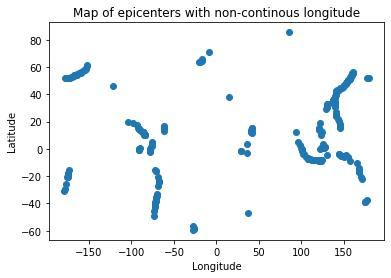

In [32]:
# latitude with non-continous scale
plt.scatter(volcanoes_engineered['Longitude'], volcanoes_engineered['Latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of epicenters with non-continous longitude')
plt.show()

Add new columns ...


,Longitude,geo_x,Latitude,geo_y
0,14.999,14.999,37.748,37.748
1,41.830,41.830,15.550,15.550
2,42.180,42.180,15.050,15.050
3,40.553,40.553,13.793,13.793
4,41.700,41.700,13.370,13.370
...,...,...,...,...
269,-26.533,333.467,-59.017,-59.017
270,-26.483,333.517,-57.800,-57.800
271,-27.570,332.430,-56.300,-56.300
272,145.780,145.780,16.580,16.580


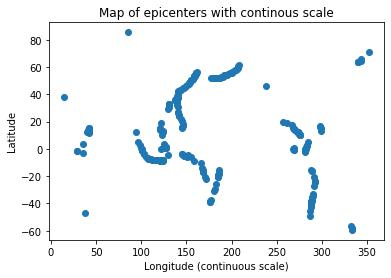

In [33]:
# add columns geo_x and geo_y (but preserve lon and lat)
try:
    # lat for geo_y should not be changed, fill geo_x with NaN
    print("Add new columns ...")
    volcanoes_engineered.insert(1, "geo_y", volcanoes_engineered['Latitude'])
    volcanoes_engineered.insert(1, "geo_x", np.nan)

except ValueError as e:
    # be verbose if this has already been done
    print(f"Error: {e}. Continue with calculations ...")   
    
# calculate the continuous geo_x value for longitude
volcanoes_engineered['geo_x'] = volcanoes_engineered.apply(lambda x: calculate_geo_x(x['Longitude']), axis = 1)

# show new parts of dataframe
display(volcanoes_engineered[['Longitude', 'geo_x', 'Latitude', 'geo_y']])

# Map (scatterplot of geo_x and geo_y)
#plt.figure(figsize = (16, 8))
plt.scatter(volcanoes_engineered['geo_x'], volcanoes_engineered['geo_y'])
plt.xlabel('Longitude (continuous scale)')
plt.ylabel('Latitude')
plt.title('Map of epicenters with continous scale')
plt.show()

### Geometry
For drawing maps and conversion to geopandas dataframe, a geometry information (point) is necessary and built from *Longitude* and *Latitude*.

In [34]:
# create a geometry column
volcanoes_engineered['geometry'] = volcanoes_engineered.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

# display results
display(volcanoes_engineered[['Volcano_Number','geometry']])

,Volcano_Number,geometry
0,211060,POINT (14.999 37.748)
1,221010,POINT (41.83 15.55)
2,221020,POINT (42.18 15.05)
3,221060,POINT (40.553 13.793)
4,221101,POINT (41.7 13.37)
...,...,...
269,390080,POINT (-26.533 -59.017)
270,390090,POINT (-26.483 -57.8)
271,390130,POINT (-27.57 -56.3)
272,284193,POINT (145.78 16.58)


### Primary_Volcano_Type
Simplify the *Primary_Volcano_Type* feature by reducing the number of different types, especially with low counts.

In [35]:
# Check the feature 'Primary_Volcano_Type' with the aim of simplifying the used types
table, count, count_of_items = create_ascii_table(volcanoes_engineered, 'Primary_Volcano_Type')
print(table)
print("\nTotal count:", count)
print("Count of items:", count_of_items)

Primary_Volcano_Type      Count  Percentage
----------------------  -------  ------------
Stratovolcano               155  56.57%
Stratovolcano(es)            40  14.60%
Caldera                      23  8.39%
Complex                      21  7.66%
Shield                       13  4.74%
Lava dome(s)                  4  1.46%
Fissure vent(s)               3  1.09%
Pyroclastic cone(s)           3  1.09%
Shield(s)                     2  0.73%
Compound                      2  0.73%
Pyroclastic cone              1  0.36%
Maar(s)                       1  0.36%
Stratovolcano?                1  0.36%
Lava cone                     1  0.36%
Lava dome                     1  0.36%
Shield(pyroclastic)           1  0.36%
Tuff cone(s)                  1  0.36%
Fissure vent                  1  0.36%

Total count: 274
Count of items: 18


In [36]:
# define the replacement rules
replacement_dict = {
    'Stratovolcano': 'Stratovolcano(es)',
    'Lava dome': 'Lava dome(s)',
    'Shield': 'Shield(s)',
    'Fissure vent': 'Fissure vent(s)',
    'Stratovolcano?': 'Stratovolcano(es)',
    'Shield(pyroclastic)': 'Shield(s)',
    'Pyroclastic cone(s)': 'Cone(s)',
    'Lava cone': 'Cone(s)',
    'Pyroclastic cone': 'Cone(s)',
}

# replace the values
volcanoes_engineered['Primary_Volcano_Type'] = volcanoes_engineered['Primary_Volcano_Type'].replace(replacement_dict)

### Drop all eruptions and volcanoes outside study area

In [37]:
# mark all volconoes outside the study area
volcanoes_engineered['Not_Study_Area'] = False
volcanoes_engineered.loc[~(volcanoes_engineered['Latitude'].between(-70, 70)), 'Not_Study_Area'] = True
volcanoes_engineered.loc[~((volcanoes_engineered['Longitude'].between(-180, -60)) | 
                           (volcanoes_engineered['Longitude'].between(100, 180))), 'Not_Study_Area'] = True

# show results
print(f"Marked volcanoes outside study area: {volcanoes_engineered[volcanoes_engineered['Not_Study_Area'] == True].shape[0]}")
display(volcanoes_engineered[['Volcano_Name','Not_Study_Area']])

Marked volcanoes outside study area: 29


,Volcano_Name,Not_Study_Area
0,Etna,True
1,"Tair, Jebel at",True
2,Zubair Group,True
3,Alu-Dalafilla,True
4,Nabro,True
...,...,...
269,Bristol Island,True
270,Saunders,True
271,Zavodovski,True
272,South Sarigan Seamount,False


#### Explicitely outside study area (buffer)
Several volcanoes, which are included in the data so far are (because of the bounding box) are outside a buffer of c. 10° away from the outer plate margin of the ptectonic plates of the Pacific Ring of Fire.

In [38]:
# provide the list of volcanoes to be deleted due to be outside the buffer
volcanoes_outside_buffer = [353080,353020,353010,353050,353060,360050,360060,360150,263280,263300,263310,263340,264010,
                            264020,264030,264050,264071,264090,264150,264160,264180,264200,264220,264250,264260,264270,
                            261140,261160,261170,261230,262000,263100,263140,263180,263210,263250,264110,263350,264230,
                            261220,263090,263200,353040,360101]

# Drop rows where the volcano is in the list
volcanoes_engineered = volcanoes_engineered[~volcanoes_engineered['Volcano_Number'].isin(volcanoes_outside_buffer)]
print("Shape of volcanoes_cleaned after dropping rows:", volcanoes_engineered.shape)

# drop associated eruptions
print("Shape of eruptions_engineered before deleting non referenced eruptions:", eruptions_engineered.shape)
used_volcano_numbers = volcanoes_engineered['Volcano_Number'].unique()
eruptions_engineered = eruptions_engineered[eruptions_engineered['Volcano_Number'].isin(used_volcano_numbers)]
print("Shape of eruptions_engineered after deleting non referenced eruptions:", eruptions_engineered.shape)

Shape of volcanoes_cleaned after dropping rows: (230, 17)
Shape of eruptions_engineered before deleting non referenced eruptions: (1600, 13)
Shape of eruptions_engineered after deleting non referenced eruptions: (1349, 13)


In [39]:
# filter volcanoes outside the study area and get unique Volcano_Number
volcanoes_outside_study = volcanoes_engineered[volcanoes_engineered['Not_Study_Area'] == True]
outside_study_ids = volcanoes_outside_study['Volcano_Number'].unique()

# add a column to mark eruptions linked to those volcanoes
eruptions_engineered['Not_Study_Area'] = eruptions_engineered['Volcano_Number'].isin(outside_study_ids)

# show results
print("Volcanoes")
print(volcanoes_engineered['Not_Study_Area'].value_counts())
print("\nEruptions")
print(eruptions_engineered['Not_Study_Area'].value_counts())

Volcanoes
False    201
True      29
Name: Not_Study_Area, dtype: int64

Eruptions
False    1252
True       97
Name: Not_Study_Area, dtype: int64


In [40]:
# finally drop all volcanoes or eruptions outside study area
volcanoes_engineered = volcanoes_engineered[volcanoes_engineered['Not_Study_Area'] == False]
eruptions_engineered = eruptions_engineered[eruptions_engineered['Not_Study_Area'] == False]

In [41]:
# drop the feature 'Not_Study_Area', it is not used any more
volcanoes_engineered.drop('Not_Study_Area', axis=1, inplace=True)
eruptions_engineered.drop('Not_Study_Area', axis=1, inplace=True)

### Checking datasets after cleaning and engineering

In [42]:
# get and show data errors
print("Volcanoes")
print("Columns with possible data errors (empty output means no columns detected):")
data_errors_volcanoes_engineered = pd.DataFrame(get_data_errors(volcanoes_engineered)).fillna(0).transpose().applymap(lambda x: int(float(x)))
display(data_errors_volcanoes_engineered)

print("\nEruptions")
print("Columns with possible data errors (empty output means no columns detected):")
data_errors_eruptions_engineered = pd.DataFrame(get_data_errors(eruptions_engineered)).fillna(0).transpose().applymap(lambda x: int(float(x)))
display(data_errors_eruptions_engineered)

Volcanoes
Columns with possible data errors (empty output means no columns detected):


""



Eruptions
Columns with possible data errors (empty output means no columns detected):


""


### Show preliminary results

In [43]:
# show the resulting datasets (all dtypes but only 20 lines (standard) of the dataframe)
print("Volcanoes")
pd.set_option('display.max_rows', None)
print("\nShape:\n" + str(volcanoes_engineered.shape))
print("\nColumns and DataTypes:\n" + str(volcanoes_engineered.dtypes))
pd.set_option('display.max_rows', 20)
display(volcanoes_engineered)

# show the resulting datasets (all dtypes but only 20 lines (standard) of the dataframe)
print("\nEruptions")
pd.set_option('display.max_rows', None)
print("\nShape:\n" + str(eruptions_engineered.shape))
print("\nColumns and DataTypes:\n" + str(eruptions_engineered.dtypes))
pd.set_option('display.max_rows', 20)
display(eruptions_engineered)

Volcanoes

Shape:
(201, 16)

Columns and DataTypes:
Volcano_Number            int64
geo_x                   float64
geo_y                   float64
Volcano_Name             object
Primary_Volcano_Type     object
Country                  object
Region                   object
Latitude                float64
Longitude               float64
Elevation                 int64
Tectonic_Setting         object
Evidence_Category        object
Major_Rock_Type          object
Erupting                   bool
Last_Activity_Year      float64
geometry                 object
dtype: object


,Volcano_Number,geo_x,geo_y,Volcano_Name,Primary_Volcano_Type,Country,Region,Latitude,Longitude,Elevation,Tectonic_Setting,Evidence_Category,Major_Rock_Type,Erupting,Last_Activity_Year,geometry
13,241040,177.1800,-37.5200,Whakaari/White Island,Stratovolcano(es),New Zealand,Tonga-Kermadec Volcanic Regions,-37.5200,177.1800,294,Subduction zone / Continental crust (> 25 km),Eruption Observed,Andesite / Basaltic Andesite,True,2019.0,POINT (177.18 -37.52)
14,241050,176.5069,-38.1569,Okataina,Lava dome(s),New Zealand,Tonga-Kermadec Volcanic Regions,-38.1569,176.5069,1111,Subduction zone / Continental crust (> 25 km),Eruption Observed,Rhyolite,True,1981.0,POINT (176.5069 -38.1569)
15,241080,175.6320,-39.1570,Tongariro,Stratovolcano(es),New Zealand,Tonga-Kermadec Volcanic Regions,-39.1570,175.6320,1978,Subduction zone / Continental crust (> 25 km),Eruption Observed,Andesite / Basaltic Andesite,True,2012.0,POINT (175.632 -39.157)
16,241100,175.5700,-39.2800,Ruapehu,Stratovolcano(es),New Zealand,Tonga-Kermadec Volcanic Regions,-39.2800,175.5700,2797,Subduction zone / Continental crust (> 25 km),Eruption Observed,Andesite / Basaltic Andesite,True,2007.0,POINT (175.57 -39.28)
17,242030,182.0800,-29.2700,Raoul Island,Stratovolcano(es),New Zealand,Tonga-Kermadec Volcanic Regions,-29.2700,-177.9200,516,Subduction zone / Oceanic crust (< 15 km),Eruption Observed,Andesite / Basaltic Andesite,True,2006.0,POINT (-177.92 -29.27)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,358041,287.3486,-42.8349,Chaiten,Caldera,Chile,South America Volcanic Regions,-42.8349,-72.6514,1122,Subduction zone / Continental crust (> 25 km),Eruption Observed,Rhyolite,True,2011.0,POINT (-72.6514 -42.8349)
254,358057,287.0300,-45.9000,"Hudson, Cerro",Stratovolcano(es),Chile,South America Volcanic Regions,-45.9000,-72.9700,1905,Subduction zone / Continental crust (> 25 km),Eruption Observed,Basalt / Picro-Basalt,True,2011.0,POINT (-72.97 -45.9)
255,358060,286.4960,-49.0190,Lautaro,Stratovolcano(es),Chile,South America Volcanic Regions,-49.0190,-73.5040,3542,Subduction zone / Continental crust (> 25 km),Eruption Observed,Dacite,True,1979.0,POINT (-73.504 -49.019)
272,284193,145.7800,16.5800,South Sarigan Seamount,Stratovolcano(es),United States,Northwest Pacific Volcanic Regions,16.5800,145.7800,-184,Subduction zone / Crustal thickness unknown,Eruption Observed,unknown,True,2010.0,POINT (145.78 16.58)



Eruptions

Shape:
(1252, 13)

Columns and DataTypes:
Volcano_Number                  int64
Eruption_Number                 int64
Activity_Type                  object
ExplosivityIndexMax           float64
StartEvidenceMethod            object
StartDateYear                   int64
StartDateMonth                float64
StartDateDay                  float64
EndDateYear                   float64
EndDateMonth                  float64
EndDateDay                    float64
StartDate              datetime64[ns]
EndDate                datetime64[ns]
dtype: object


,Volcano_Number,Eruption_Number,Activity_Type,ExplosivityIndexMax,StartEvidenceMethod,StartDateYear,StartDateMonth,StartDateDay,EndDateYear,EndDateMonth,EndDateDay,StartDate,EndDate
305,257020,20938,Confirmed Eruption,1.0,Observations: Reported,2011,9.0,17.0,2011.0,10.0,10.0,2011-09-17,2011-10-10
309,257020,15226,Confirmed Eruption,2.0,Observations: Reported,1976,1.0,15.0,1976.0,1.0,15.0,1976-01-15,1976-01-15
310,257020,15227,Confirmed Eruption,2.0,Observations: Reported,1977,4.0,13.0,1977.0,4.0,13.0,1977-04-13,1977-04-13
311,257020,15228,Confirmed Eruption,1.0,Observations: Reported,1980,7.0,2.0,1980.0,7.0,2.0,1980-07-02,1980-07-02
312,257020,15229,Confirmed Eruption,1.0,Observations: Reported,1981,7.0,9.0,1981.0,7.0,9.0,1981-07-09,1981-07-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,341040,10460,Confirmed Eruption,1.0,Observations: Reported,1977,12.0,16.0,1982.0,6.0,16.0,1977-12-16,1982-06-16
10748,341040,10461,Uncertain Eruption,1.0,unknown,1983,2.0,11.0,1983.0,2.0,15.0,1983-02-11,1983-02-15
10865,357010,11899,Confirmed Eruption,2.0,Observations: Reported,1987,11.0,28.0,1987.0,11.0,30.0,1987-11-28,1987-11-30
10866,357010,20561,Confirmed Eruption,2.0,Observations: Reported,1980,1.0,10.0,1980.0,1.0,11.0,1980-01-10,1980-01-11


In [44]:
# list categorical columns
print("Volcanoes")
cat_col_volcanoes = get_categorical_columns(volcanoes_engineered)
print("Categorical Columns:\n", cat_col_volcanoes)

print("\nEruptions")
cat_col_eruptions = get_categorical_columns(eruptions_engineered)
print("Categorical Columns:\n", cat_col_eruptions)

Volcanoes
Categorical Columns:
 ['Volcano_Name', 'Primary_Volcano_Type', 'Country', 'Region', 'Tectonic_Setting', 'Evidence_Category', 'Major_Rock_Type', 'geometry']

Eruptions
Categorical Columns:
 ['Activity_Type', 'StartEvidenceMethod']


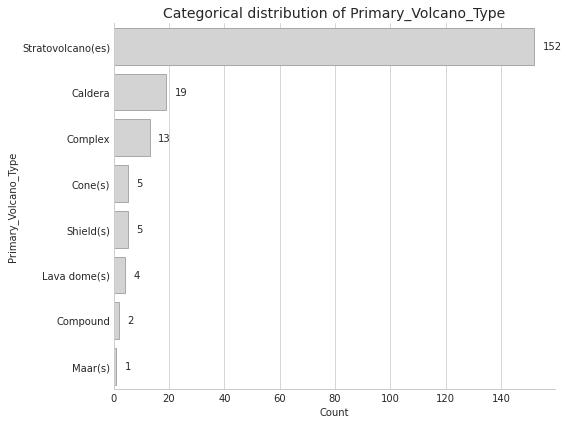

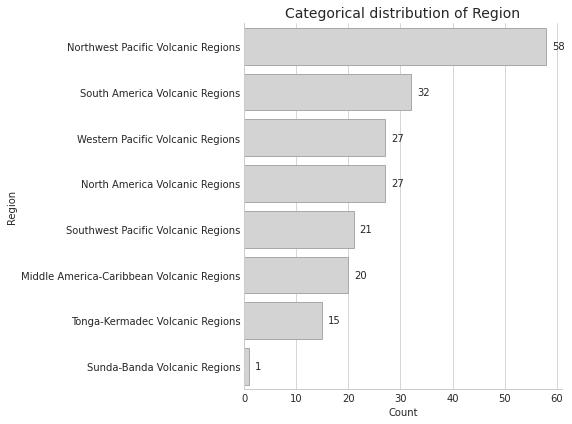

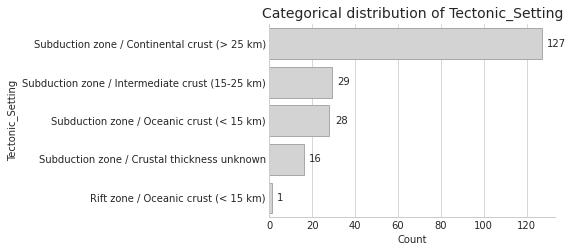

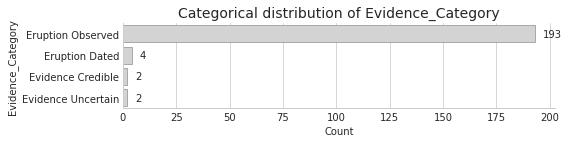

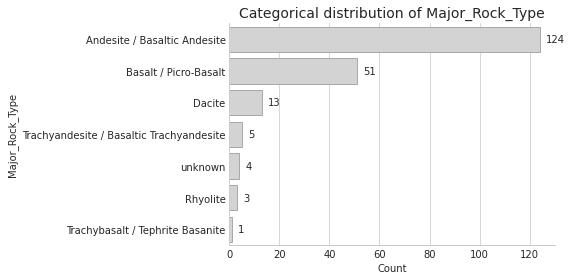

In [45]:
# Primary_Volcano_Type (Type of the volcano)
fig1 = plot_categorical_distribution(volcanoes_engineered, 'Primary_Volcano_Type', figsize=(8, 6))
plt.show()

# Region (Larger region where this volcano belongs to)
fig2 = plot_categorical_distribution(volcanoes_engineered, 'Region')
plt.show()

# Tectonic_Setting (Type of tectonic setting where the volcano is located)
fig3 = plot_categorical_distribution(volcanoes_engineered, 'Tectonic_Setting', figsize=(8, 3.6))
plt.show()

# Evidence_Category (Type of evidence of identifying this volcano)                        
fig4 = plot_categorical_distribution(volcanoes_engineered, 'Evidence_Category', figsize=(8, 2.1))
plt.show()

# Major_Rock_Type (Main rock type this volcano consists of)
fig5 = plot_categorical_distribution(volcanoes_engineered, 'Major_Rock_Type', figsize=(8, 4.0))
plt.show()

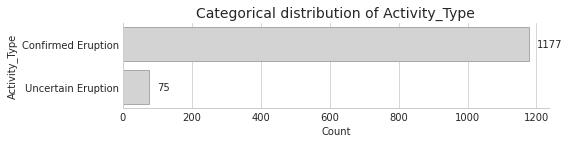

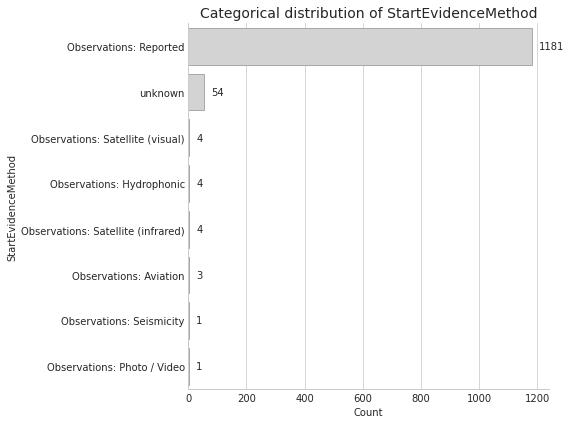

In [46]:
# Activity_Type (Status of confirmation of this eruption)
fig6 = plot_categorical_distribution(eruptions_engineered, 'Activity_Type', figsize=(8, 2.1))
plt.show()

# StartEvidenceMethod (Type of evidence of identifying this eruption)
fig7 = plot_categorical_distribution(eruptions_engineered, 'StartEvidenceMethod')
plt.show()

In [47]:
# list numeric columns
print("Volcanoes")
num_col_volcanoes = get_numerical_columns(volcanoes_engineered)
print("Numerical Columns:\n", num_col_volcanoes)

print("\nEruptions")
num_col_eruptions = get_numerical_columns(eruptions_engineered)
print("Numerical Columns:\n", num_col_eruptions)

Volcanoes
Numerical Columns:
 ['Volcano_Number', 'geo_x', 'geo_y', 'Latitude', 'Longitude', 'Elevation', 'Last_Activity_Year']

Eruptions
Numerical Columns:
 ['Volcano_Number', 'Eruption_Number', 'ExplosivityIndexMax', 'StartDateYear', 'StartDateMonth', 'StartDateDay', 'EndDateYear', 'EndDateMonth', 'EndDateDay']


Last_Activity_Year (Year of the last known eruption)


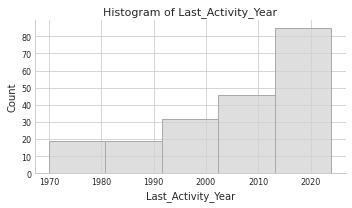

,Last_Activity_Year
count,201.000000
mean,2005.840796
std,15.033780
min,1970.000000
25%,1995.000000
50%,2011.000000
75%,2018.000000
max,2024.000000



Elevation (Elevation of the (highest) peak of the volcano)


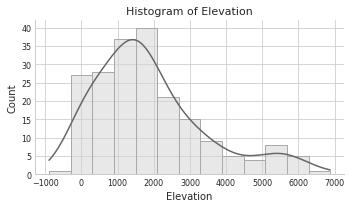

,Elevation
count,201.000000
mean,1879.348259
std,1554.576836
min,-897.000000
25%,746.000000
50%,1573.000000
75%,2507.000000
max,6879.000000



Latitude (Latitude of the volcano)


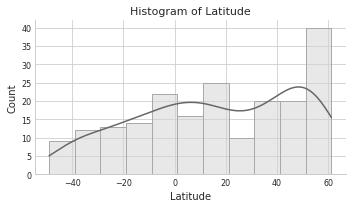

,Latitude
count,201.000000
mean,15.837662
std,31.082686
min,-49.019000
25%,-5.525000
50%,15.130000
75%,46.200000
max,61.299000



Longitude (Longitude of this volcano)


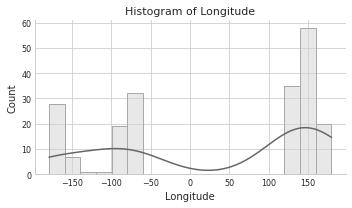

,Longitude
count,201.000000
mean,31.975697
std,133.735230
min,-179.033000
25%,-85.622000
50%,125.447000
75%,147.120000
max,179.580000


In [48]:
# Last_Activity_Year (Year of the last known eruption)
print("Last_Activity_Year (Year of the last known eruption)")
print("==============================================================")
fig11 = plot_numerical_distribution(volcanoes_engineered, 'Last_Activity_Year', kde=False, bins=5)
plt.show()
display(get_statistical_values(volcanoes_engineered, 'Last_Activity_Year'))
print()

# Elevation (Elevation of the (highest) peak of the volcano)
print("Elevation (Elevation of the (highest) peak of the volcano)")
print("==============================================================")
fig12 = plot_numerical_distribution(volcanoes_engineered, 'Elevation')
plt.show()
display(get_statistical_values(volcanoes_engineered, 'Elevation'))
print()

# Latitude (Latitude of the volcano)
print("Latitude (Latitude of the volcano)")
print("==============================================================")
fig13 = plot_numerical_distribution(volcanoes_engineered, 'Latitude', bins=11)
plt.show()
display(get_statistical_values(volcanoes_engineered, 'Latitude'))
print()

# Longitude (Longitude of this volcano)
print("Longitude (Longitude of this volcano)")
print("==============================================================")
fig14 = plot_numerical_distribution(volcanoes_engineered, 'Longitude', bins=18)
plt.show()
display(get_statistical_values(volcanoes_engineered, 'Longitude'))
print()

ExplosivityIndexMax (Explosivity index (1-9) of this eruption)


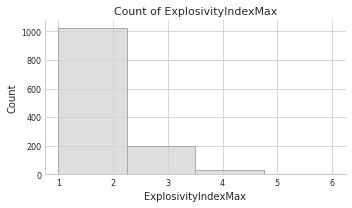

,ExplosivityIndexMax
count,1252.000000
mean,1.798722
std,0.810245
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,6.000000




StartDateYear (Year of eruption starting)


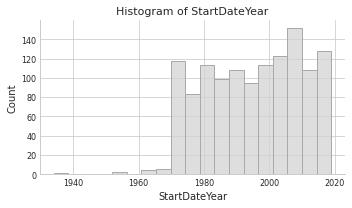

,StartDateYear
count,1252.000000
mean,1995.335463
std,14.720880
min,1934.000000
25%,1983.000000
50%,1996.000000
75%,2008.000000
max,2019.000000



StartDateMonth (Month of eruption starting)


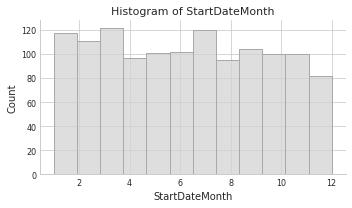

,StartDateMonth
count,1252.000000
mean,6.254792
std,3.430213
min,1.000000
25%,3.000000
50%,6.000000
75%,9.000000
max,12.000000



StartDateDay (Day of eruption starting)


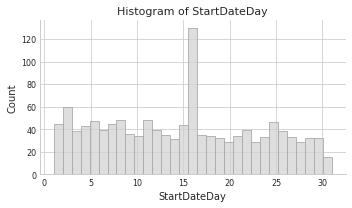

,StartDateDay
count,1252.000000
mean,14.798722
std,8.564015
min,1.000000
25%,7.000000
50%,15.000000
75%,22.000000
max,31.000000


In [49]:
# ExplosivityIndexMax (Explosivity index (1-9) of this eruption)
print("ExplosivityIndexMax (Explosivity index (1-9) of this eruption)")
print("==============================================================")
fig11 = plot_numerical_distribution(eruptions_engineered, 'ExplosivityIndexMax', bins=4, kde=False, title='Count of ExplosivityIndexMax')
plt.show()
display(get_statistical_values(eruptions_engineered, 'ExplosivityIndexMax'))
print()

# StartDateYear (Year of eruption starting)
print("\nStartDateYear (Year of eruption starting)")
print("===========================================")
fig13 = plot_numerical_distribution(eruptions_engineered, 'StartDateYear', kde=False)
plt.show()
display(get_statistical_values(eruptions_engineered, 'StartDateYear'))
print()

# StartDateMonth (Month of eruption starting)
print("StartDateMonth (Month of eruption starting)")
print("===========================================")
fig13 = plot_numerical_distribution(eruptions_engineered, 'StartDateMonth', bins=12, kde=False)
plt.show()
display(get_statistical_values(eruptions_engineered, 'StartDateMonth'))
print()

# StartDateDay (Day of eruption starting)
print("StartDateDay (Day of eruption starting)")
print("=======================================")
fig13 = plot_numerical_distribution(eruptions_engineered, 'StartDateDay', bins=31, kde=False)
plt.show()
display(get_statistical_values(eruptions_engineered, 'StartDateDay'))
print()

## Selecting
The final volcano and eruption dataset is selected according to the following contraints:

+ Study area with a bounding box of longitude [100°;-60°] and latitude [-70°;70°].
+ The time period is set to 5 complete decades, with t=[01.01.1970; 31.12.2019].
+ VEI with VEI≥1.0.

In [50]:
# make a deep copy of the datasets for further processing
volcanoes_selected = volcanoes_engineered.copy()
eruptions_selected = eruptions_engineered.copy()
logging.info(f"{script_name}: Used dataset is 'volcanoes_selected' with {volcanoes_selected.shape}.")
logging.info(f"{script_name}: Used dataset is 'eruptions_selected' with {eruptions_selected.shape}.")

2025-01-22 02:15:55,993 - INFO - 21_engineer_volcanic_eruption_data.ipynb: Used dataset is 'volcanoes_selected' with (201, 16).
2025-01-22 02:15:55,994 - INFO - 21_engineer_volcanic_eruption_data.ipynb: Used dataset is 'eruptions_selected' with (1252, 13).


#### Check timeframe and VEI

Beware of the eruptions which have started in the past and are ongoing when the timeframe starts (see above).

In [51]:
# find min and max values for each relevant column / feature
min_mag = eruptions_selected['ExplosivityIndexMax'].min()
max_mag = eruptions_selected['ExplosivityIndexMax'].max()

min_time = eruptions_selected['StartDateYear'].min()
max_time = eruptions_selected['StartDateYear'].max()

# show min and max values
print(f"VEI: min = {min_mag}, max = {max_mag}")
print(f"Time: min = {min_time}, max = {max_time}")

VEI: min = 1.0, max = 6.0
Time: min = 1934, max = 2019


In [52]:
# count rows that are outside the specified conditions for longitude
outside_conditions_count_lon = volcanoes_selected[(
        ~((volcanoes_selected['Longitude'].between(-180, -60)) | (volcanoes_selected['Longitude'].between(100, 180)))
)].shape[0]

# print count of lon coordinates outside the specified bounding box
print(f"Longitude coordinates outside bounding box: {outside_conditions_count_lon}")

Longitude coordinates outside bounding box: 0


In [53]:
# count rows that are outside the specified conditions for latitude
outside_conditions_count_lat = volcanoes_selected[(
    ~(volcanoes_selected['Latitude'].between(-70, 70))
)].shape[0]

# print count of Latitude coordinates outside the specified bounding box
print(f"Longitude coordinates outside bounding box: {outside_conditions_count_lat}")

Longitude coordinates outside bounding box: 0


## Save cleaned, engineered, and selected datasets

In [54]:
# save datasets
print(f"volcanoes_selected {volcanoes_selected.shape}")
save_dataset(data_file = "volcanoes_selected.csv", 
             data_dir = data_dir, 
             data_set = volcanoes_selected
            )  

print(f"eruptions_selected {eruptions_selected.shape}")
save_dataset(data_file = "eruptions_selected.csv", 
             data_dir = data_dir, 
             data_set = eruptions_selected
            )

2025-01-22 02:15:56,045 - INFO - save_dataset: Data saved successfully to 'data/volcanoes_selected_250122-021556.csv'.
2025-01-22 02:15:56,073 - INFO - save_dataset: Data saved successfully to 'data/eruptions_selected_250122-021556.csv'.


volcanoes_selected (201, 16)
eruptions_selected (1252, 13)


## End of script

In [55]:
# log the end of this script
logging.info(f"End of script '{script_name}'.")

2025-01-22 02:15:56,078 - INFO - End of script '21_engineer_volcanic_eruption_data.ipynb'.


## Appendix

In [56]:
%%js

// -------------------------------------------
// What are the headings of this document?
// --> Get a better overview of the structure.
// -------------------------------------------

function listHeadings() {
    let headings = [];
    let cells = Jupyter.notebook.get_cells();
    
    cells.forEach((cell) => {
        if (cell.cell_type == 'markdown') {
            let text = cell.get_text();
            let lines = text.split('\n');
            
            lines.forEach((line) => {
                let match = line.match(/^(#+)\s+(.*)/);
                if (match) {
                    headings.push({
                        level: match[1].length, // Number of # symbols indicates the heading level
                        text: match[2].trim()
                    });
                }
            });
        }
    });
    return headings;
}

let headings = listHeadings();
headings.forEach((heading) => {
    let markdown = `${'#'.repeat(heading.level)} ${heading.text}`;
    element.append(`${markdown}<br>`);
});

<IPython.core.display.Javascript object>